# CBS FINAL PROJECT
## Kacper Domżał 386308

The aim of my project was to build a classifier using deeplearing that would decide whether someone has pneumonia or not by analyzing chest Xray 
photo. I thought it would be an interesting project due to the fact that because current pandemic many chest Xray photos are being made 
as a part of COVID-19 diagnosis. The dataset I chose for this task comes from kaggle - 5856 chest Xray photos, mostly of people with pneumonia (pneumonia:healthy lungs are in around 3:1 ratio).   

To achieve my task I decided to use tensorflow library. I build 2 classyfiers in total. The first one is a pretty simple convolutional 
network build by hand and trained from scratch. The second model is based on a already pretrained and constructed DenseNet169 network - I decided 
to try transfer learning. DenseNet169 has 169 layers as the name suggest, which is a lot compared to the first network I created. My goal 
was to try and find out by how much a complicated DL network such as DenseNet169 outperforms a simple network such as my own convolutional network.  

All the parameters used in networks were chosen by trial and error in order to achieve the best performing classifier. Unfortunately, I did 
not have enough computation resources to perform some broad optimal parameters search in loops etc. so I did mostly by hand. 

In [1]:
import os 
import tensorflow as tf
import sys
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib
import matplotlib.pyplot as plt
import random
import cv2
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
import glob
import numpy as np
import pandas as pd
import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import warnings
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
warnings.filterwarnings('ignore')

## Making sure that tensorflow is using GPU acceleration

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## My main model performance testing function

In [66]:
def eval_model(model, threshold = 0.5):
    """Main testing function. It takes in trained model and returns performance stats and visualizes the Xray images
    that were wrongly classified"""
    test_set_info = []
    test_path_normal = test_path + '/NORMAL'
    test_path_pneumonia = test_path + '/PNEUMONIA'
    for filename in os.listdir(test_path_normal):
        test_set_info.append((os.path.join(test_path_normal,filename), 0))
    for filename in os.listdir(test_path_pneumonia):
        test_set_info.append((os.path.join(test_path_pneumonia,filename), 1))
    
    test_data_df = pd.DataFrame(test_set_info, columns = ['jpg_path','result'], index=None)

    pred_list = []
    for image in test_data_df.jpg_path:
        im = cv2.imread(image)
        test_image = np.asarray(im)
        processed_test_image = cv2.resize(test_image/255, tuple(image_size))
        processed_test_image = np.expand_dims(processed_test_image, axis = 0)
        if processed_test_image.shape[-1] == 3:
            ps = model.predict(processed_test_image)
        else:
            ps = model.predict(tf.image.rgb_to_grayscale(processed_test_image))
        pred_list.append(ps[0][0])

    pred_list  = np.where(np.array(pred_list)>threshold,1,0)
    actual_label = test_data_df['result']
    test_data_df['predicted'] = pred_list

    print('Classification report: \n    ',classification_report(actual_label, pred_list))
    matrix=confusion_matrix(actual_label, pred_list)
    ax = plt.axes()
    sns.heatmap(matrix, annot=True, square=True, fmt='d', cbar=False,
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
    ax.set_title('Confusion matrix:')
    print('Confusion matrix:\n')
    plt.show()
    print('\n\nWrong classification examples: \n')
    rslt_df = test_data_df[test_data_df['result'] !=  test_data_df['predicted']]
    rslt = rslt_df.loc[random.sample(set(rslt_df.index), 9)]
    plt.figure(figsize=(20,12))
    counter = 0
    for index, row in rslt.iterrows():
        counter += 1
        plt.subplot(3, 3, counter)
        img = plt.imread(row['jpg_path'])
        plt.imshow(img, cmap='Greys')
        plt.title(f"True: {labels_dict[row['result']]} vs Predicted: {labels_dict[row['predicted']]}")

## Setting up paths to all the required dirs

In [4]:
my_data_dir = 'C://Users//kacdo//Desktop//chest_xray'
test_path = my_data_dir+'//test'
train_path = my_data_dir+'//train'
val_path = my_data_dir+'//val'

## Defining parameters for data preprocessing and training

In [5]:
image_size = [200, 200]
image_shape = image_size + [3]
batch_size = 16
epochs = 30

## Creating image generators that will feed images. I applied data augmentation to training dataset to achieve better model generalization. Data augmntation turned out to be vital - without it model classified all images to one class (the more frequent one - pneumonia)

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range=0.12,
    brightness_range=[0.2,1.0],
    zoom_range=0.18,
    width_shift_range=0.12,
    height_shift_range=0.12)

training_set = train_datagen.flow_from_directory(
    directory = train_path,
    shuffle=True,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'binary')


val_datagen = ImageDataGenerator(rescale = 1./255)

val_set = val_datagen.flow_from_directory(
    directory = val_path,
    shuffle=True,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'binary')


test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory(
    shuffle=True,
    directory = test_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'binary')

Found 5064 images belonging to 2 classes.
Found 87 images belonging to 2 classes.
Found 748 images belonging to 2 classes.


## Before working with the data I decided to visualize all the subsets (train, validation, test). At first glance you can see that the Xray images of infected lungs are noticably more frequent

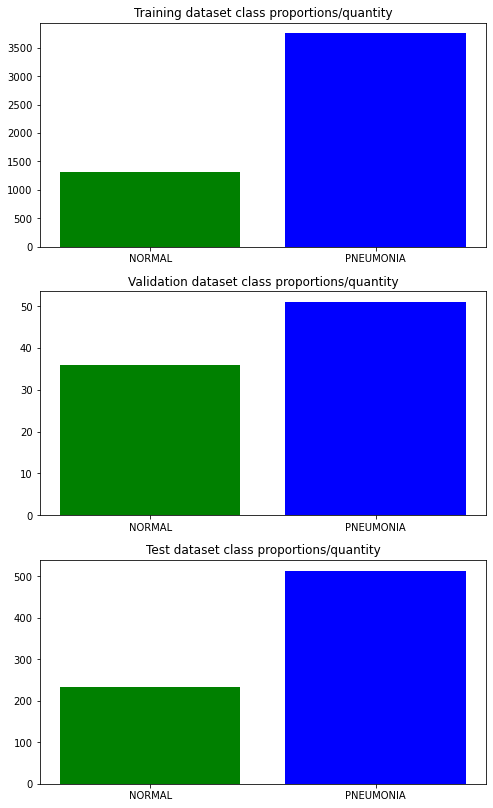

In [58]:
labels_dict = {val: key for key, val in training_set.class_indices.items()}

plt.figure(figsize=(8,14))

plt.subplot(3, 1, 1)
train = {labels_dict[x]: list(training_set.labels).count(x) for x in training_set.labels}
plt.bar(train.keys(), train.values(), color=['green', 'blue'])
plt.title("Training dataset class proportions/quantity")

plt.subplot(3, 1, 2)
val = {labels_dict[x]: list(val_set.labels).count(x) for x in val_set.labels}
plt.bar(val.keys(), val.values(), color=['green', 'blue'])
plt.title("Validation dataset class proportions/quantity")


plt.subplot(3, 1, 3)
test = {labels_dict[x]: list(test_set.labels).count(x) for x in test_set.labels}
plt.bar(test.keys(), test.values(), color=['green', 'blue'])
plt.title("Test dataset class proportions/quantity")
plt.show()

# Constructing first network
## I decided to use convolutional network due to the fact that my dataset is made out of images and convolutional networks are considered to be the best for image processing. I'm also adding dropout layer to prevent overfitting.

In [8]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=image_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0

## Compiling my model. I am using binary crossentropy loss function because - in my case it's a binary classyfication - pneumonia or not

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

## Training my model. I'm using early stoping to get better generalization and ReduceLROnPlateau to make learning rate flexible

In [10]:
history = model.fit(
    training_set,
    epochs=epochs,
    validation_data=val_set,
    callbacks=[EarlyStopping(monitor = 'val_loss', patience=4, restore_best_weights=True), 
    ReduceLROnPlateau(monitor = 'val_loss', patience=3)])

Epoch 1/30
317/317 [==============================] - 71s 215ms/step - loss: 0.4430 - accuracy: 0.7964 - val_loss: 0.5474 - val_accuracy: 0.8506
Epoch 2/30
317/317 [==============================] - 68s 214ms/step - loss: 0.3270 - accuracy: 0.8535 - val_loss: 0.6512 - val_accuracy: 0.8506
Epoch 3/30
317/317 [==============================] - 68s 214ms/step - loss: 0.2829 - accuracy: 0.8888 - val_loss: 0.3950 - val_accuracy: 0.8506
Epoch 4/30
317/317 [==============================] - 68s 214ms/step - loss: 0.2760 - accuracy: 0.8888 - val_loss: 0.3838 - val_accuracy: 0.8621
Epoch 5/30
317/317 [==============================] - 67s 212ms/step - loss: 0.2363 - accuracy: 0.9048 - val_loss: 0.5169 - val_accuracy: 0.8391
Epoch 6/30
317/317 [==============================] - 67s 210ms/step - loss: 0.2412 - accuracy: 0.9056 - val_loss: 0.3104 - val_accuracy: 0.8851
Epoch 7/30
317/317 [==============================] - 69s 217ms/step - loss: 0.2262 - accuracy: 0.9113 - val_loss: 0.4362 - val_ac

## Plotting training accuracy in both validation and training dataset

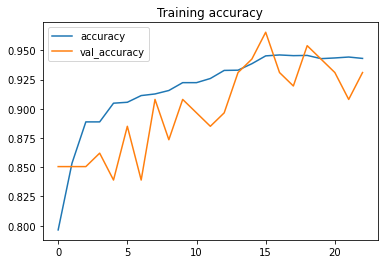

In [11]:
pd.DataFrame(model.history.history)[['accuracy', 'val_accuracy']].plot(title='Training accuracy')
plt.show()

## Checking model accuracy on training set

In [12]:
print('Evaluated model accuracy: ', model.evaluate(test_set)[1])

47/47 [==============================] - 6s 118ms/step - loss: 0.5265 - accuracy: 0.8369
Evaluated model accuracy:  0.8368983864784241


## Running my main testing function on trained model to evaluate performance on training set and see some random images from training dataset that have been misclassified by the model.

Classification report: 
                   precision    recall  f1-score   support

           0       0.81      0.64      0.71       234
           1       0.85      0.93      0.89       514

    accuracy                           0.84       748
   macro avg       0.83      0.78      0.80       748
weighted avg       0.84      0.84      0.83       748

Confusion matrix:



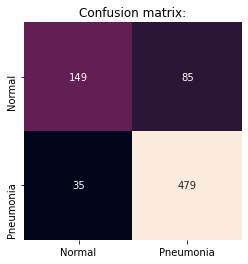



Wrong classification examples: 



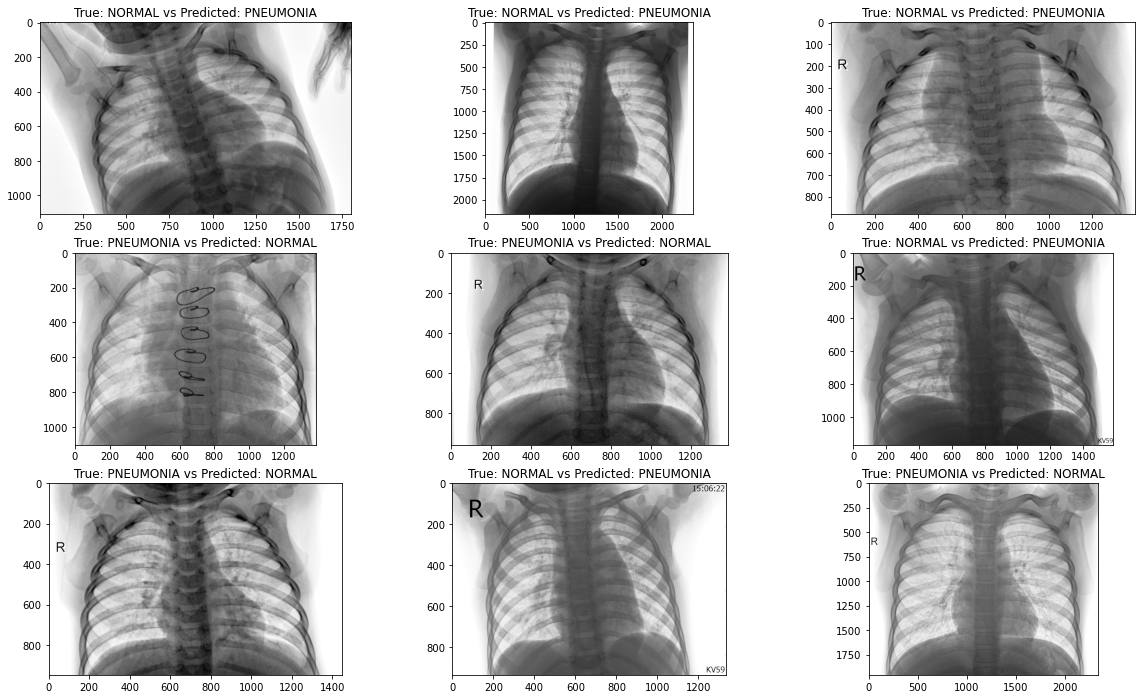

In [67]:
eval_model(model)

# Transfer learning
## Here I'm importing already pretrained DenseNet169 network and adding new layers that will be trained on my chest Xray dataset

In [59]:
base = DenseNet169(weights='imagenet', input_shape=image_shape, include_top=False)

for layer in base.layers:
    layer.trainable=False 
    
densenet_model = Sequential()
densenet_model.add(base)
densenet_model.add(GlobalAveragePooling2D())
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(256, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(128, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(Dense(64, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(Dense(1, activation='sigmoid'))
densenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 6, 6, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1664)              6656      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               426240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

## Compiling model

In [61]:
densenet_model.compile(loss='binary_crossentropy', 
                       optimizer=Adam(lr=0.001), 
                    metrics=['accuracy'])

## Training model. Early stopping and ReduceLROnPlateau used are previously.

In [62]:
dense_history = densenet_model.fit(training_set,
                              epochs=epochs,
                              validation_data = val_set,
                              callbacks=[EarlyStopping(monitor = 'val_loss', patience=4, restore_best_weights=True), 
                            ReduceLROnPlateau(monitor = 'val_loss', patience=3)])

Epoch 1/30
317/317 [==============================] - 85s 244ms/step - loss: 0.3374 - accuracy: 0.8568 - val_loss: 0.2106 - val_accuracy: 0.8966
Epoch 2/30
317/317 [==============================] - 72s 228ms/step - loss: 0.2188 - accuracy: 0.9175 - val_loss: 0.2507 - val_accuracy: 0.8391
Epoch 3/30
317/317 [==============================] - 71s 224ms/step - loss: 0.1922 - accuracy: 0.9236 - val_loss: 0.1827 - val_accuracy: 0.9425
Epoch 4/30
317/317 [==============================] - 72s 227ms/step - loss: 0.1872 - accuracy: 0.9323 - val_loss: 0.1715 - val_accuracy: 0.9310
Epoch 5/30
317/317 [==============================] - 71s 224ms/step - loss: 0.1689 - accuracy: 0.9311 - val_loss: 0.1527 - val_accuracy: 0.9540
Epoch 6/30
317/317 [==============================] - 72s 226ms/step - loss: 0.1797 - accuracy: 0.9362 - val_loss: 0.2037 - val_accuracy: 0.9310
Epoch 7/30
317/317 [==============================] - 71s 225ms/step - loss: 0.1674 - accuracy: 0.9380 - val_loss: 0.1913 - val_ac

## Plotting training accuracy in both validation and training dataset

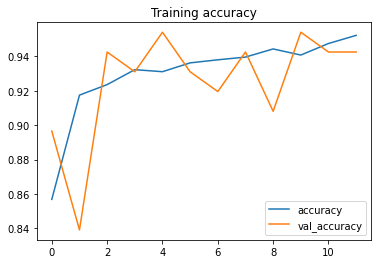

In [63]:
pd.DataFrame(dense_history.history)[['accuracy', 'val_accuracy']].plot(title='Training accuracy')
plt.show()

## Checking model accuracy on training set

In [64]:
print('Evaluated model accuracy: ', densenet_model.evaluate(test_set)[1])

47/47 [==============================] - 7s 146ms/step - loss: 0.3134 - accuracy: 0.8850
Evaluated model accuracy:  0.885026752948761


## Running my main testing function on trained model to evaluate performance on training set and see some random images from training dataset that have been misclassified by the model.

Classification report: 
                   precision    recall  f1-score   support

           0       0.80      0.86      0.83       234
           1       0.93      0.90      0.92       514

    accuracy                           0.89       748
   macro avg       0.87      0.88      0.87       748
weighted avg       0.89      0.89      0.89       748

Confusion matrix:



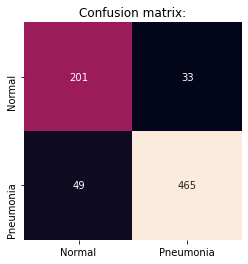



Wrong classification examples: 



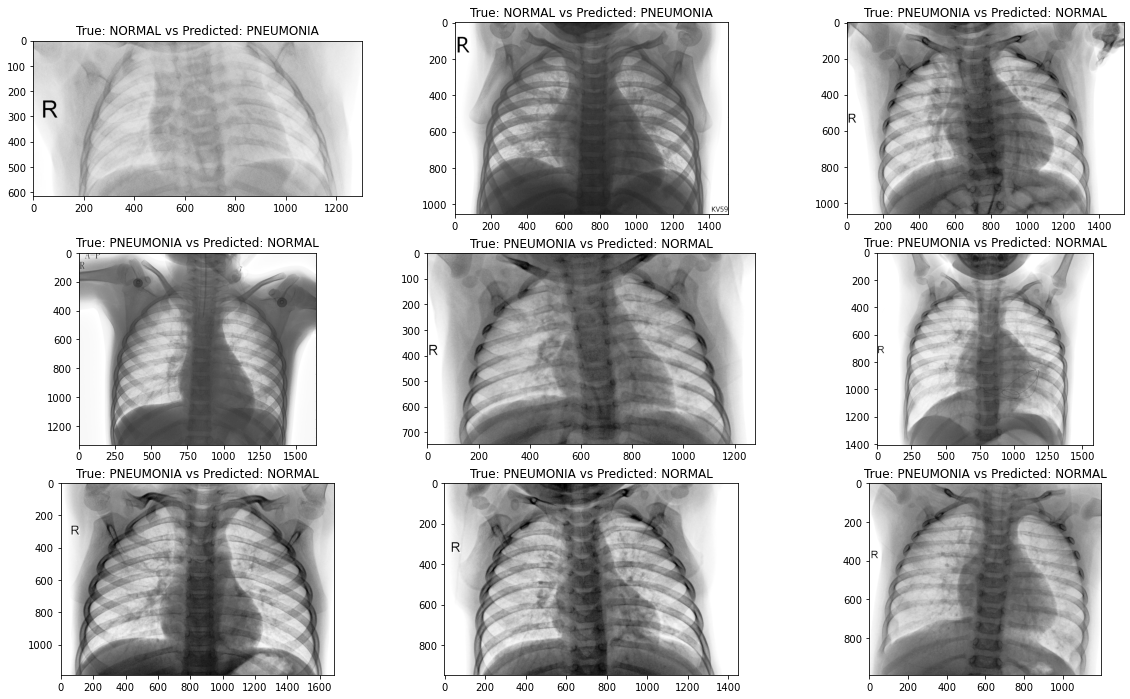

In [68]:
eval_model(densenet_model)

# Conclusions
To sum up, my models performance. First model that has 10 layers achieved 84% and the modified DenseNet169 that has 180 layers got 89% accuracy. 
Such small difference between models so different suggests the deciding whether someone has pneumonia based on their chest Xray is pretty 
straight forward, and it pretty much is, in most cases. As you can see on the images above sometimes deciding whether someone has pneumonia is difficult, it's not visible at first glance, sometimes it's not visible for me at all. Hence, the difference in performance. The more complex model is able to learn some properties from the dataset that are not comprehensible to most humans. It is also worth to take into consideration 
that pneumonia vary from case to case. Some cases are severe and the chest Xray chest images are pretty easy to classify and some are milder, for example the pneumonia was caught early and the infections hasn't spread across lungs so much. All in all, I am content with the results of my project. I got 89% accuracy model, which in my opinion is rather decent considering I had to work with a small, imbalanced training dataset and the problem in question wasn't that trivial. 